<h2> Construction des Modèles de Deep Learning sur les Données de l'Herbier </h2>

In [1]:
import os
import zipfile
from pathlib import Path
import re
import cv2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import PIL


c:\Users\Dorian\anaconda3\envs\GPU_py38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---

In [3]:
relativeProjectPath = Path.cwd().parent
dataPath = relativeProjectPath / 'Data'

---

#### Feature Engineering 

##### Load the Initial **Datasets** of Images based on the Herbarium

In [9]:
# Function that verify a Path and its content
def verifyFolderPathContent(initPath, labelPath='',):
    if not (os.path.exists(initPath)):  # Verify whether the current path exists or not 
        return print(f'{labelPath} Path -> Not Validated (Path does not Exists) \nVeriy the path or Reexecute the file: "InitializationDataHerbarium.ipynb"')
    if not os.listdir(initPath): # Verify whether the current path has empty content or not 
        return print(f'{labelPath} Path -> Not Validated (Path Exists BUT Path Content is Empty) \nVeriy the path or Reexecute the file: "InitializationDataHerbarium.ipynb"')
    return print(f'{labelPath} Path -> Validated (Path Exists AND Path Content is not Empty)')

In [10]:
initDatasetPath = dataPath / 'Dataset'
verifyFolderPathContent(initDatasetPath, 'Dataset')

Dataset Path -> Validated (Path Exists AND Path Content is not Empty)


##### Transform the IMAGES from both the **Train** and **Test** Initial Dataset

Calculate the **Ratio** between the Height and Width.

In [12]:
# Find the best imageShape
ls_ratioHeightWidth = []
for dir_, _, files in os.walk(initDatasetPath):
    for file_name in files:
      imagePath = (initDatasetPath / dir_ / file_name).__str__()
      imageHeight, imageWidth = cv2.imread(imagePath).shape[:2]
      ls_ratioHeightWidth.append(round(imageHeight/imageWidth, 2))     
      
print('Ratio Height/Width Minimum:', np.min(ls_ratioHeightWidth))
print('Ratio Height/Width Mean:', np.mean(ls_ratioHeightWidth))
print('Ratio Height/Width Median:', np.median(ls_ratioHeightWidth))
print('Ratio Height/Width Maximum:', np.max(ls_ratioHeightWidth))

ratioHeightWidth = np.median(ls_ratioHeightWidth)

print(f'\nExample: \nWidth:{500} \nHeight: {int(500 * ratioHeightWidth)}')

Ratio Height/Width Minimum: 1.28
Ratio Height/Width Mean: 1.5455454545454548
Ratio Height/Width Median: 1.55
Ratio Height/Width Maximum: 1.7

Example: 
Width:500 
Height: 775.0


Transform the Datasets

In [13]:
# Function that transform a 3D-Image into a 2D-Image
def grayscaleImage(Image):
    dcopyImage = np.zeros(Image.shape[:2])
    for row in range(dcopyImage.shape[0]):
        for col in range(dcopyImage.shape[1]):
            dcopyImage[row][col] = (sum(Image[row, col] * 1/3))
    return dcopyImage

In [255]:
def getBackgroundBGR(Image):
    
    im = PIL.Image.fromarray(Image)
    background_color = im.getcolors(im.size[0]*im.size[1])

    x_result = []
    for x in sorted(background_color, reverse=True)[:20]:
        x_result.append(x[1])
                            
    blue_value = int(np.median(list(map(lambda x: x[0], x_result))))
    green_value = int(np.median(list(map(lambda x: x[1], x_result))))
    red_value = int(np.median(list(map(lambda x: x[2], x_result))))
    return  (blue_value, green_value, red_value)

In [90]:
def manageImageRatioSize(Image, imageSize=512, ratioHeightWidth=1, imageInterpolation=cv2.INTER_AREA, imageBorderType=cv2.BORDER_CONSTANT):
    
    # Step ~1: Resize the Image
    resizedImage = cv2.resize(Image, (imageSize, imageSize), interpolation=imageInterpolation)

    # Step ~2: Get the Padding 
    padding = abs(int((imageSize * ratioHeightWidth - imageSize) / 2))
    
    # Step ~3: Apply the Padding to the Image
    if ratioHeightWidth > 1: #Verify whether the padding should be apply (>1 is Height | <1 is Width)
        return cv2.copyMakeBorder(resizedImage, padding, padding, 0, 0,  borderType=imageBorderType)
    return cv2.copyMakeBorder(resizedImage, 0, 0, padding, padding, borderType=imageBorderType)

In [262]:
def makeImageTransformation(imagePath, prevFolderName='Dataset', uptFolderName='Transformed_Dataset', prctImage=0.01, imageSize=512, ratioHeightWidth=1):
    
    # Step ~0: Read the Image
    Image = cv2.imread(imagePath)
    
    # Step ~1: Remove Image Borders
    prctHeight, prctWidth = int(Image.shape[0]*prctImage), int(Image.shape[1]*prctImage)
    Image = Image[prctHeight:-prctHeight, prctWidth:-prctWidth]
    
    # Step ~2: Convert to Grayscale and Apply a GaussianBlur
    grayImage = cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)
    gaussianImage = cv2.GaussianBlur(grayImage, (51, 51), 0)
  
    # Step ~3: Apply a Binary and Otsu Threshold 
    _, threshImage = cv2.threshold(gaussianImage, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Step ~4: Apply a Binary and Otsu Threshold 
    colorizedImage = cv2.bitwise_or(Image, Image, mask=cv2.bitwise_not(threshImage))
    
    # Step ~5: Apply the Image Resize and Padding
    resizedPaddedImage = manageImageRatioSize(colorizedImage, imageSize, ratioHeightWidth)
    
    # Step ~5: Apply a Smooth modification of the Background Color
    backgroundColor = getBackgroundBGR(Image)
    preprocessedImage = np.where(resizedPaddedImage==[0, 0, 0], backgroundColor, resizedPaddedImage)

    # Step ~X: Save the Transformed Image following a similar Path (except for the main directory name)
    newImagePath = imagePath.__str__().replace(prevFolderName, uptFolderName)
    Path(newImagePath).parent.mkdir(parents=True, exist_ok=True)  # Verify whether the Folder exists and Create it
    cv2.imwrite(newImagePath, preprocessedImage)

In [263]:
transformFolder = 'Transformed_Dataset'
prctImage = 0.02
imageSize = 512

# Loop through each FILE and apply an IMAGE transformation
for dir_, _, files in os.walk(initDatasetPath):
    for file_name in files:
      imagePath = (initDatasetPath / dir_ / file_name).__str__()
      makeImageTransformation(imagePath, prevFolderName=initDatasetPath.name, uptFolderName=transformFolder,  prctImage=prctImage, imageSize=imageSize, ratioHeightWidth=ratioHeightWidth)

##### Load the Transformed **Train** and **Test** Datasets Images based on the Herbarium

In [11]:
modifDatasetPath = dataPath / 'Transformed_Dataset'
trainPath = modifDatasetPath / 'Train'
testPath = modifDatasetPath / 'Test'
verifyFolderPathContent(trainPath, 'Train')
verifyFolderPathContent(testPath, 'Test')

Train Path -> Validated (Path Exists AND Path Content is not Empty)
Test Path -> Validated (Path Exists AND Path Content is not Empty)


##### Visualize a Sample from the Transformed **Train** Dataset

In [ ]:
dictTrainDir = dict()
for specie in os.listdir(trainPath):
    dictTrainDir.update({specie: (trainPath / specie)})

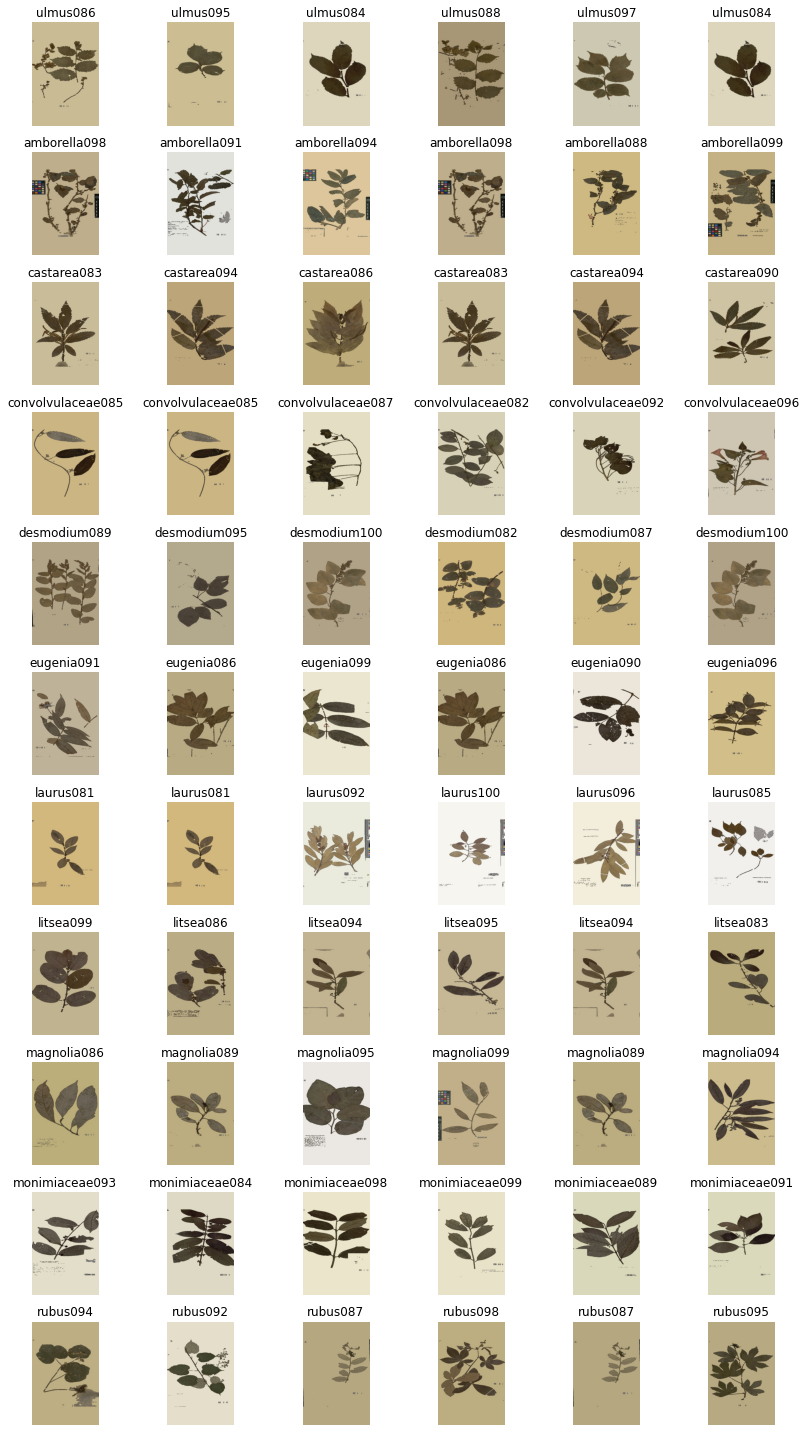

In [ ]:
lsPathsImage = []

numbSample = 6 # We set the number of images we want to show per category

# Loop through each category
for curKey in dictTrainDir:
    lsFiles = random.choices(os.listdir(dictTrainDir[curKey]), k=numbSample)
    lsPaths = list(map(lambda fileName : os.path.join(dictTrainDir[curKey], fileName), lsFiles))
    lsPathsImage.append(lsPaths)


# Set the Figures and Axes
fig, axes = plt.subplots(nrows=len(lsPathsImage), ncols=numbSample, figsize=(12,20))
fig.set_facecolor('white')

# Original
for row in range(len(lsPathsImage)):
    for col in range(numbSample):
        imagePath = lsPathsImage[row-1][col-1]
        imageTitle = imagePath.split('\\')[-1].split('.')[0]
        curImage = cv2.imread(imagePath)
        
        axes[(row, col)].imshow(np.array(cv2.cvtColor(curImage, cv2.COLOR_BGR2RGB)))
        axes[(row, col)].set_title(imageTitle) 
        axes[(row, col)].axis('off')

# Thight the Layout
plt.tight_layout()

# Display the Figure
plt.show()

##### Build the Dataframe with the Species and their corresponding Attribute 

In [9]:
# Définir les Informations connu d'après les 4 caractères descriptifs des 11 taxons
# Devrions-nous faire une transformation binaire?
# Bord : { Lisse = 0 / Denté = 1 }
# Phyllotaxie : { Opposé = 0 / Alterné = 1 }
# Type Feuille : { Simple = 0 / Composée = 1 }
# Ligneux : { Non = 0 / Oui = 1 }

def makeBinaryHerbarium(lsHerbarium):
    lsHerbarium[0] = 0 if (lsHerbarium[0]=='lisse') else 1
    lsHerbarium[1] = 0 if (lsHerbarium[1]=='opposé') else 1
    lsHerbarium[2] = 0 if (lsHerbarium[2]=='simple') else 1
    lsHerbarium[3] = 0 if (lsHerbarium[3]=='non') else 1
    return lsHerbarium

Herbarium = dict({
    'amborella': ['lisse', 'alterné', 'simple', 'oui'],
    'castanea': ['denté', 'alterné', 'simple', 'oui'],
    'desmodium': ['lisse', 'alterné', 'composée', 'non'],
    'eugenia': ['lisse', 'opposé', 'simple', 'oui'],
    'laurus': ['lisse', 'opposé', 'simple', 'oui'],
    'litsea': ['lisse', 'alterné', 'simple', 'oui'],
    'magnolia': ['lisse', 'alterné', 'simple', 'oui'],
    'rubus': ['denté', 'alterné', 'composée', 'oui'],
    'ulmus': ['denté', 'alterné', 'simple', 'oui'],
    'monimiaceae': ['lisse', 'opposé', 'simple', 'oui'],
    'convolvulaceae': ['lisse', 'alterné', 'simple', 'non']
})

binaryHerbarium = {herb: makeBinaryHerbarium(Herbarium[herb].copy()) for herb in Herbarium.keys()}

In [276]:
def getFilesPath(dirPath):
    lsPathFiles = []
    for dir_, _, files in os.walk(dirPath):
        for file_name in files:
            lsPathFiles.append(re.search(rf'{dirPath.name}.*', (initDatasetPath / dir_ / file_name).__str__()).group())
    return lsPathFiles

def makeDataFrame(dirPath, savePath):
    lsPathImages, lsHerbarium = getFilesPath(dirPath), [] 
    
    # Append Information about the Images and the attributes to the corresponding Species
    for pathImage in lsPathImages:  # Loop through each Images
        typeImage = pathImage.split('\\')[-3]
        shapeImage = cv2.imread(((dirPath.parent / pathImage).__str__())).shape
        sizeImage = np.product(shapeImage)
        nameHerbarium = pathImage.split('\\')[-2]  
        lsHerbarium.append([pathImage, typeImage, shapeImage, sizeImage, nameHerbarium] + Herbarium[nameHerbarium] + binaryHerbarium[nameHerbarium])
    
    # Build the Dataframe and divide it as Test and Train   
    dfImageHerbarium = pd.DataFrame (lsHerbarium, columns = ['ImagePath', 'Type', 'ImageShape', 'ImageSize', 'Herbarium', 'Bord', 'Phyllotaxie', 'TypeFeuille', 'Ligneux', 'binaryBord', 'binaryPhyllotaxie', 'binaryTypeFeuille', 'binaryLigneux'])
    dfImageHerbariumTest = dfImageHerbarium[dfImageHerbarium['Type'] == 'Test']
    dfImageHerbariumTrain = dfImageHerbarium[dfImageHerbarium['Type'] == 'Train']
    
    # Split and Save into two SubDatasets (Test and Train)
    filenameTrain, filenameTest = 'transformedTrainDataset.csv', 'transformedTestDataset.csv'
    dfImageHerbariumTrain.to_csv(path_or_buf=(savePath / filenameTrain), index = 0)
    dfImageHerbariumTest.to_csv(path_or_buf=(savePath / filenameTest), index = 0)
    
    print('Dataframe Succesfully Created')
    print(f'Train Dataframe Path -> {re.search(rf"{savePath.name}.*", (savePath / filenameTrain).__str__()).group()} ')
    print(f'Test Dataframe Path -> {re.search(rf"{savePath.name}.*", (savePath / filenameTest).__str__()).group()} ')

In [277]:
makeDataFrame(modifDatasetPath, dataPath)

Dataframe Succesfully Created
Train Dataframe Path -> Data\transformedTrainDataset.csv 
Test Dataframe Path -> Data\transformedTestDataset.csv 


---

#### Deep Learning Models

##### Model of Object Detection for the Species Attributes 

In this **Section**, we want to realize a object recognition from different vegetal species. The purpose is to use the *Train* and *Test* data to build a model that allow the object recognition and in our case the detection of vegetal attributes.

An attribute represents a descriptive character of vegetal. For instance an attribute of the *magnolia* can be the arrangement of its leaves that are alternate. 

##### Step 1: Load the Transformed **Dataframe** of **Train** and **Test**

Ces jeux de données ont été construit avec le notebook **InitializationDataHerbarium** avec l'attribution des caractèristiques aux végétaux.

In [5]:
testFilename, trainFilename = 'transformedTrainDataset.csv', 'transformedTrainDataset.csv'

if testFilename in os.listdir(dataPath):
    dfTest = pd.read_csv(filepath_or_buffer=(dataPath / testFilename))
    print('Test Dataframe -> Successfully Loaded')
else:
    print('Test Dataframe -> Unsuccessfully Loaded | Modify the Path or Reexecute the current Notebook')

if trainFilename in os.listdir(dataPath):
    dfTrain = pd.read_csv(filepath_or_buffer=(dataPath / trainFilename))
    print('Train Dataframe -> Successfully Loaded')
else:
    print('Test Dataframe -> Unsuccessfully Loaded | Modify the Path or Reexecute the current Notebook')

Test Dataframe -> Successfully Loaded
Train Dataframe -> Successfully Loaded


##### Step 2: Construct the Generator for each Attribute

In [6]:
def constructGeneratorfromDataframe(generator, df, colsFeature, targetSize, batchSize):
    return generator.flow_from_dataframe(df, x_col=colsFeature[0], y_col=colsFeature[1], target_size=targetSize, batch_size=batchSize, class_mode="sparse")

In [12]:
# All images will be rescaled by 1./255
trainGenerator = ImageDataGenerator(rescale=1./255)
testGenerator = ImageDataGenerator(rescale=1./255)

inputShape = cv2.imread((modifDatasetPath / 'test' / 'amborella'  / 'amborella071.jpg').__str__()).shape
target_size = (512, 512)    
batch_size = 32
print('Input Shape:', inputShape)
print('Target Size:', target_size)
print('Bach Size:', batch_size)

dfTrain['ImageAbsolutePath'] = (dataPath / dfTrain['ImagePath']) # Get Absolute Path
dfTrain['ImageAbsolutePath'] = dfTrain['ImageAbsolutePath'].astype(str)  # Get Absolute Path
dfTest['ImageAbsolutePath'] = (dataPath / dfTest['ImagePath']) # Get Absolute Path
dfTest['ImageAbsolutePath'] = dfTest['ImageAbsolutePath'].astype(str)  # Get Absolute Path


print('\nTrain Generator:')
trainGeneratorBord = constructGeneratorfromDataframe(trainGenerator, dfTrain, ['ImageAbsolutePath', 'Bord'], target_size, batch_size)
trainGeneratorPhyllotaxie = constructGeneratorfromDataframe(trainGenerator, dfTrain, ['ImageAbsolutePath', 'Phyllotaxie'], target_size, batch_size)
trainGeneratorTypeFeuille = constructGeneratorfromDataframe(trainGenerator, dfTrain, ['ImageAbsolutePath', 'TypeFeuille'], target_size, batch_size)
trainGeneratorLigneux = constructGeneratorfromDataframe(trainGenerator, dfTrain, ['ImageAbsolutePath', 'Ligneux'], target_size, batch_size)

print('\nTest Generator:')
testGeneratorBord = constructGeneratorfromDataframe(testGenerator, dfTest, ['ImageAbsolutePath', 'Bord'], target_size, batch_size)
testGeneratorPhyllotaxie = constructGeneratorfromDataframe(testGenerator, dfTest, ['ImageAbsolutePath', 'Phyllotaxie'], target_size, batch_size)
testGeneratorTypeFeuille = constructGeneratorfromDataframe(testGenerator, dfTest, ['ImageAbsolutePath', 'TypeFeuille'], target_size, batch_size)
testGeneratorLigneux = constructGeneratorfromDataframe(testGenerator, dfTest, ['ImageAbsolutePath', 'Ligneux'], target_size, batch_size)


Input Shape: (792, 512, 3)
Target Size: (512, 512)
Bach Size: 32

Train Generator:
Found 220 validated image filenames belonging to 2 classes.
Found 220 validated image filenames belonging to 2 classes.
Found 220 validated image filenames belonging to 2 classes.
Found 220 validated image filenames belonging to 2 classes.

Test Generator:
Found 220 validated image filenames belonging to 2 classes.
Found 220 validated image filenames belonging to 2 classes.
Found 220 validated image filenames belonging to 2 classes.
Found 220 validated image filenames belonging to 2 classes.


##### Step 3: Construct the Model

In [13]:
def makeModel_ObjectRecognition(inputShape, outputSize, outputActivationFunction, choiceOptimizer, choiceLoss, choiceMetrics):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=inputShape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(512, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(outputSize, activation = outputActivationFunction))  # Tester Softmax
    model.compile(optimizer=choiceOptimizer, loss=choiceLoss, metrics=choiceMetrics)
    return model

In [14]:
outputActivationFunction = 'sigmoid'
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = 'sparse_categorical_crossentropy'
metrics = ['accuracy']

print('Output Activation Function:', outputActivationFunction)
print('Optimize:', optimizer)
print('Loss:', loss)
print('Metrics:', metrics)


modelBord = makeModel_ObjectRecognition((512, 512, 3), len(trainGeneratorBord.class_indices), outputActivationFunction, optimizer, loss, metrics)

modelBord.summary()

Output Activation Function: sigmoid
Optimize: <keras.optimizer_v2.adam.Adam object at 0x000001E42C4BFA00>
Loss: sparse_categorical_crossentropy
Metrics: ['accuracy']
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 510, 510, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPo

In [15]:
epochs = 15
modelBord.fit(trainGeneratorBord, epochs=epochs, validation_data=testGeneratorBord)  # Probable Overfitting (Try Data Augmentation)

Epoch 1/15
7/7 [==============================] - 14s 1s/step - loss: 0.7824 - accuracy: 0.5682 - val_loss: 0.6972 - val_accuracy: 0.7273
Epoch 2/15
7/7 [==============================] - 3s 482ms/step - loss: 0.6715 - accuracy: 0.7273 - val_loss: 0.6284 - val_accuracy: 0.7273
Epoch 3/15
7/7 [==============================] - 3s 475ms/step - loss: 0.5960 - accuracy: 0.7273 - val_loss: 0.5891 - val_accuracy: 0.7273
Epoch 4/15
7/7 [==============================] - 3s 471ms/step - loss: 0.5931 - accuracy: 0.7273 - val_loss: 0.5961 - val_accuracy: 0.7273
Epoch 5/15
7/7 [==============================] - 3s 492ms/step - loss: 0.6060 - accuracy: 0.7273 - val_loss: 0.5981 - val_accuracy: 0.7273
Epoch 6/15
7/7 [==============================] - 3s 493ms/step - loss: 0.5814 - accuracy: 0.7273 - val_loss: 0.5882 - val_accuracy: 0.7273
Epoch 7/15
7/7 [==============================] - 3s 470ms/step - loss: 0.5950 - accuracy: 0.7273 - val_loss: 0.5909 - val_accuracy: 0.7273
Epoch 8/15
7/7 [======